# RECAP: Introduction to Graph Neural Networks and Graph Attention Networks

## Overview

This notebook introduces the fundamentals of Graph Neural Networks (GNNs) and specifically Graph Attention Networks (GATs). We'll cover the following topics:

1. Understanding graph-structured data
2. The need for specialized neural networks for graphs
3. Message passing in GNNs
4. Limitations of previous GNN approaches
5. Introduction to Graph Attention Networks
6. The key innovation: attention mechanism

By the end of this notebook, you'll have a solid understanding of why GATs were developed and how they address limitations in previous graph neural network architectures.

## 1. Understanding Graph-Structured Data

### What are graphs?

A graph G = (V, E) consists of:
- A set of nodes/vertices V
- A set of edges E connecting pairs of nodes

Each node can have its own features or attributes, and edges may also have features.

### Why are graphs important?

Graphs are a natural representation for many real-world data types:
- Social networks (users connected by friendships)
- Molecular structures (atoms connected by bonds)
- Citation networks (papers connected by citations)
- Recommendation systems (users connected to products)
- Knowledge graphs (entities connected by relationships)
- Transportation networks (locations connected by routes)

### Mathematical Representation of Graphs

Graphs can be represented in several ways:

1. **Adjacency Matrix**: An N×N matrix A where N is the number of nodes. A[i,j] = 1 if there's an edge from node i to node j, otherwise 0.
2. **Edge List**: A list of pairs (i,j) indicating edges between nodes i and j.
3. **Adjacency List**: For each node, maintain a list of its neighboring nodes.

For node features, we typically use an N×F matrix X, where N is the number of nodes and F is the feature dimension.

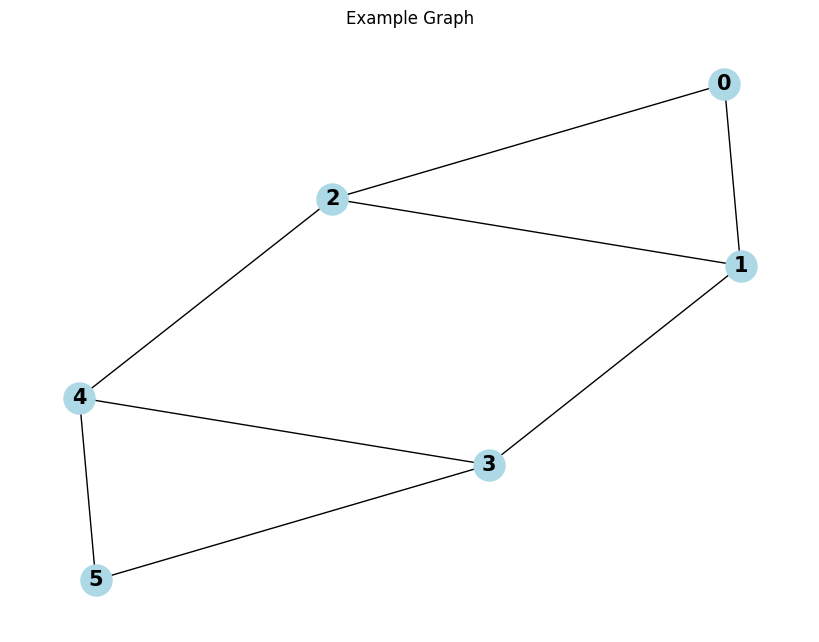

Adjacency Matrix:
[[0 1 1 0 0 0]
 [1 0 1 1 0 0]
 [1 1 0 0 1 0]
 [0 1 0 0 1 1]
 [0 0 1 1 0 1]
 [0 0 0 1 1 0]]

Node Feature Matrix (random features):
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]
 [ 0.54256004 -0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024 -1.72491783]
 [-0.56228753 -1.01283112  0.31424733]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Let's create a simple graph to visualize
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 5)])

# Visualize the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=15, font_weight='bold')
plt.title("Example Graph")
plt.show()

# Create adjacency matrix
A = nx.adjacency_matrix(G).toarray()
print("Adjacency Matrix:")
print(A)

# Create a feature matrix (for example, random features for each node)
np.random.seed(42)
X = np.random.randn(len(G.nodes), 3)  # 3 features per node
print("\nNode Feature Matrix (random features):")
print(X)

## 2. Why We Need Specialized Neural Networks for Graphs

Traditional neural networks like CNNs and RNNs are designed for grid-like (images) or sequential data (text). They're not suitable for graph data due to several challenges:

### Challenges of Graph Data

1. **Variable Size and Shape**: Graphs can have arbitrary numbers of nodes and edges.
2. **No Natural Ordering**: Unlike sequences or grids, nodes in a graph have no inherent order.
3. **Permutation Invariance**: The representation of a graph should be invariant to node ordering.
4. **Complex Dependencies**: Information flows along edges in complex patterns.
5. **Inductive Learning**: Models need to generalize to unseen, differently structured graphs.

These challenges necessitate specialized architectures designed specifically for graph-structured data.

## 3. Message Passing in Graph Neural Networks

The core paradigm of modern GNNs is **message passing**, also known as neural message passing or neighborhood aggregation. The intuition is:

1. Each node starts with its own features
2. Nodes exchange information (messages) with their neighbors
3. Each node updates its representation based on the messages received
4. This process repeats for multiple iterations/layers

Mathematically, for a node v at layer l+1:

$h_v^{(l+1)} = \text{UPDATE}\left(h_v^{(l)}, \text{AGGREGATE}\left(\{h_u^{(l)} : u \in \mathcal{N}(v)\}\right)\right)$

Where:
- $h_v^{(l)}$ is the feature representation of node v at layer l
- $\mathcal{N}(v)$ is the set of neighbors of node v
- AGGREGATE is a function that combines messages from neighbors
- UPDATE is a function that combines the node's current representation with the aggregated message

Different GNN architectures primarily differ in how they define these AGGREGATE and UPDATE functions.

### Example: A Simple Message Passing Layer

Let's implement a basic message passing layer to illustrate the concept. This is a simplified version of what we'll build later.

In [4]:
import torch
import torch.nn as nn

class SimpleMessagePassing(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleMessagePassing, self).__init__()
        # Transform node features
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x, adj_matrix):
        # x: Node features [num_nodes, in_features]
        # adj_matrix: Adjacency matrix [num_nodes, num_nodes]
        
        # Transform node features
        h = self.linear(x)  # [num_nodes, out_features]
        
        # Message passing: multiply by adjacency matrix to aggregate neighbor features
        # This is equivalent to taking the sum of neighbor features
        output = torch.matmul(adj_matrix, h)  # [num_nodes, out_features]
        
        return output

# Example usage
def demonstrate_simple_gnn():
    # Convert our example to PyTorch tensors
    adj_tensor = torch.FloatTensor(A)  # Adjacency matrix
    x_tensor = torch.FloatTensor(X)    # Node features
    
    # Create a simple message passing layer
    mp_layer = SimpleMessagePassing(in_features=3, out_features=5)
    
    # Apply message passing
    output = mp_layer(x_tensor, adj_tensor)
    
    print("Input feature shape:", x_tensor.shape)
    print("Output feature shape:", output.shape)
    print("\nFirst node features before message passing:", x_tensor[0])
    print("First node features after message passing:", output[0])
    
    return output

# We'll run this after creating the tensors in the previous cell
output = demonstrate_simple_gnn()

Input feature shape: torch.Size([6, 3])
Output feature shape: torch.Size([6, 5])

First node features before message passing: tensor([ 0.4967, -0.1383,  0.6477])
First node features after message passing: tensor([ 1.3226, -0.0468,  0.8097, -0.0393,  0.5177],
       grad_fn=<SelectBackward0>)


## 4. Limitations of Previous GNN Approaches

Early GNN architectures like Graph Convolutional Networks (GCN) and GraphSAGE faced several limitations:

1. **Equal Importance to All Neighbors**: They treat all neighbors equally when aggregating messages, regardless of their relevance or importance to the central node.

2. **Fixed Weights**: The contribution of each neighbor is predetermined by the graph structure and doesn't adapt during learning.

3. **Limited Expressiveness**: Equal weighting can limit the model's ability to capture complex relationships between nodes.

4. **No Adaptive Mechanism**: Without a mechanism to focus on more important neighbors, these models might struggle with noisy or irrelevant connections.

Let's look at how a basic GCN layer aggregates information:

In [3]:
class SimpleGCN(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleGCN, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x, adj):
        # Normalize adjacency matrix (simplified version)
        # In a real GCN, we would use D^(-1/2) A D^(-1/2) where D is the degree matrix
        deg = adj.sum(dim=1).unsqueeze(1)
        deg = torch.clamp(deg, min=1.0)  # Avoid division by zero
        norm_adj = adj / deg
        
        # Apply linear transformation and then aggregate
        h = self.linear(x)
        output = torch.matmul(norm_adj, h)
        
        return output

In this GCN example, the contribution of each neighbor is fixed based on the node degree, not learned. This means a node can't selectively pay more attention to certain neighbors based on the context or task.

## 5. Introduction to Graph Attention Networks

Graph Attention Networks (GATs) were introduced by Veličković et al. in their 2018 paper "[Graph Attention Networks](https://arxiv.org/abs/1710.10903)". The key innovation of GATs is the introduction of **attention mechanisms** to GNNs.

### Key Idea

Instead of treating all neighbors equally or using fixed weights, GATs enable each node to **attend** differently to its neighbors. The attention coefficients:

1. Are learned during training
2. Are computed dynamically for each pair of connected nodes
3. Allow the model to focus on the most relevant neighbors for each node
4. Can be different for the same neighbor depending on the task or context

### Benefits of GATs

1. **Adaptability**: Attention weights adapt to the data and task
2. **Interpretability**: Attention weights can be visualized to understand which connections are important
3. **Inductive Learning**: GATs can be applied to unseen graphs as they don't rely on global graph structure
4. **Anisotropic**: Unlike isotropic GCNs, GATs can assign different importances to different neighbors

### Attention Mechanism in GATs

At a high level, the attention mechanism computes how important node j is to node i based on their features. Mathematically, for a node pair (i,j) where j is a neighbor of i, the attention coefficient is:

$\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}(i)} \exp(e_{ik})}$

where $e_{ij}$ is an attention score computed from node features, typically using a neural network.

These attention coefficients are then used to compute a weighted sum of neighbor features:

$h_i^{(l+1)} = \sigma\left(\sum_{j \in \mathcal{N}(i)} \alpha_{ij} W h_j^{(l)}\right)$

where:
- $W$ is a learnable weight matrix
- $\sigma$ is a non-linear activation function
- $h_j^{(l)}$ is the feature of node j at layer l

We'll implement this mechanism in detail in the next notebook.

## 6. Key Innovation: Multi-Head Attention

Inspired by Transformer architectures, GATs also incorporate **multi-head attention**. Instead of using a single attention mechanism, multiple independent attention mechanisms (heads) are applied, and their outputs are concatenated or averaged.

This brings several benefits:
1. **Stability**: Multiple heads provide more stable training
2. **Expressiveness**: Different heads can capture different aspects of node relationships
3. **Ensemble Effect**: Combining multiple heads reduces noise and improves performance

Mathematically, with K attention heads, the output feature for node i becomes:

$h_i^{(l+1)} = \Big\Vert_{k=1}^K \sigma\left(\sum_{j \in \mathcal{N}(i)} \alpha_{ij}^k W^k h_j^{(l)}\right)$

where $\Vert$ represents concatenation and $\alpha_{ij}^k$ is the attention coefficient from the k-th attention head.

## Summary

In this notebook, we've covered:

1. The fundamentals of graph-structured data and its representation
2. Why we need specialized neural networks for graph data
3. The message passing paradigm in GNNs
4. Limitations of previous GNN approaches
5. Introduction to Graph Attention Networks (GATs)
6. The key innovations: attention mechanism and multi-head attention

In the next notebook, we'll dive deeper into the GAT architecture by implementing the core GAT layer with step-by-step explanations.

## References

1. Veličković, P., Cucurull, G., Casanova, A., Romero, A., Liò, P., & Bengio, Y. (2018). [Graph Attention Networks](https://arxiv.org/abs/1710.10903). International Conference on Learning Representations (ICLR).
2. Kipf, T. N., & Welling, M. (2017). [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907). International Conference on Learning Representations (ICLR).
3. Hamilton, W., Ying, Z., & Leskovec, J. (2017). [Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216). Advances in Neural Information Processing Systems (NeurIPS).